# Short tutorial how to use the Python package SpharaPy

## Abstract

This short tutorial presents some of the essential functions of the SpharaPy package, such as determining a SPHARA basis for a given spatial sensor setup, spatial-harmonic analysis using the SPHARA basis, and SPHARA-based spatial filtering.

The code examples from the article *SpharaPy: A Python toolbox for spatial harmonic analysis of non-uniformly sampled data* in the journal __[SoftwareX](https://www.sciencedirect.com/journal/softwarex)__ are taken from this tutorial. All figures from the above article can be reproduced with the help of this tutorial.

The tutorial is available as IPython in a Jupyter notebook and as Python source code.

## Import modules and functions

At the beginning we import three modules of the SpharaPy package as
well as several other packages and single functions.

In [1]:
# uncomment the following line to allow interactive figures
%matplotlib notebook

# uncomment the following lines to export the tutorial
# in PDF-Format with vector graphics
# %matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

# import modules from spharapy package
import spharapy.trimesh as tm
import spharapy.spharatransform as st
import spharapy.spharafilter as sf
import spharapy.datasets as sd

In [2]:
# import additional modules used in this tutorial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import AnchoredText
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.text import Text

In [3]:
__author__ = "Uwe Graichen"
__copyright__ = "Copyright 2018-2019, Uwe Graichen"
__credits__ = ["Uwe Graichen"]
__license__ = "BSD-3-Clause"
__version__ = "1.0.12"
__maintainer__ = "Uwe Graichen"
__email__ = "uwe.graichen@tu-ilmenau.de"
__status__ = "Release"

## Import the spatial configuration of the EEG sensors and the SEP data

In this tutorial we will apply a spatial SPHARA filter to SEP data of a single subject recorded with a 256 channel EEG system with equidistant layout. The data set is one of the example data sets contained in the SpharaPy toolbox.

In [4]:
# loading the 256 channel EEG dataset from spharapy sample datasets
data_in = sd.load_eeg_256_channel_study()

The dataset includes lists of vertices, triangles, and sensor labels, as well as EEG data from previously performed experiment addressing the cortical activation related to somatosensory-evoked potentials (SEP).

In [5]:
print(data_in.keys())

dict_keys(['vertlist', 'trilist', 'labellist', 'eegdata'])


The triangulation of the EEG sensor setup consists of 256 vertices and 482 triangles. The EEG data consists of 256 channels and 369 time samples, 50 ms before to 130 ms after stimulation. The sampling frequency is 2048 Hz.

In [6]:
vertlist = np.array(data_in['vertlist'])
trilist = np.array(data_in['trilist'])
eegdata = np.array(data_in['eegdata'])
print('vertices = ', vertlist.shape)
print('triangles = ', trilist.shape)
print('eegdata = ', eegdata.shape)

vertices =  (256, 3)
triangles =  (482, 3)
eegdata =  (256, 369)


## Visualization of the EEG sensor setup and the measured data

Visualization of triangulated sensor setup

<IPython.core.display.Javascript object>


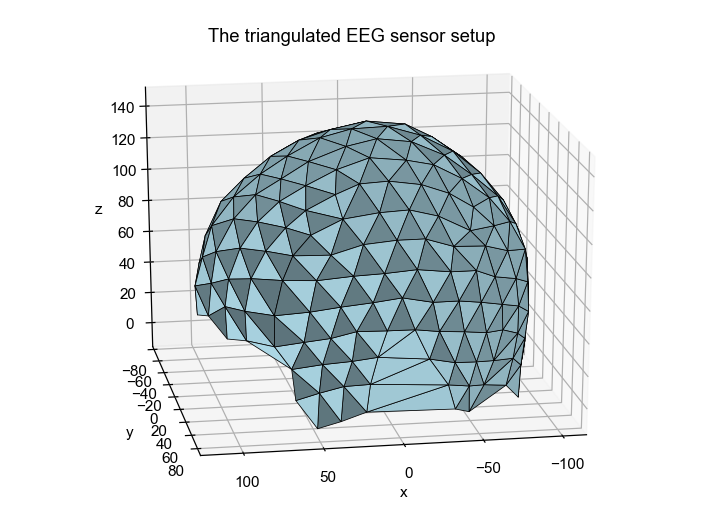

In [7]:
fig = plt.figure()
fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('The triangulated EEG sensor setup')
ax.view_init(elev=20., azim=80.)
ax.set_aspect('auto')

ax.plot_trisurf(vertlist[:, 0], vertlist[:, 1], vertlist[:, 2],
                triangles=trilist, color='lightblue', edgecolor='black',
                linewidth=0.5, shade=True)
plt.show()
fig.savefig('sensor_setup.pdf')

Visualization of the averaged SEP data as a butterfly plot. The components P14, N20 and N30, which are particularly important for the medical assessment of the SEP data are marked by red, blue and green vertical lines.

<IPython.core.display.Javascript object>


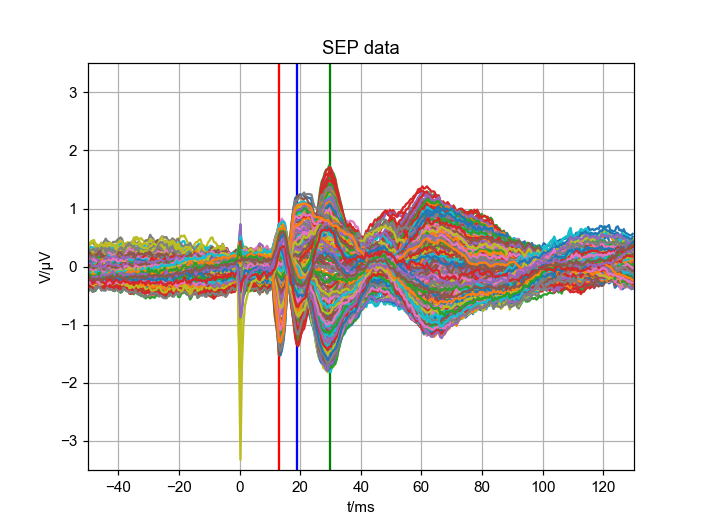

In [8]:
x = np.arange(-50, 130, 1/2.048)
figeeg = plt.figure()
axeeg = figeeg.gca()
axeeg.axvline(13, color='red')
axeeg.axvline(19, color='blue')
axeeg.axvline(30, color='green')
axeeg.plot(x, eegdata[:, :].transpose())
axeeg.set_xlabel('t/ms')
axeeg.set_ylabel('V/µV')
axeeg.set_title('SEP data')
axeeg.set_ylim(-3.5, 3.5)
axeeg.set_xlim(-50, 130)
axeeg.grid(True)
plt.show()
figeeg.savefig('sep_butterfly.pdf')

## Create a SpharaPy TriMesh instance

In the next step we create an instance of the class `spharapy.trimesh.TriMesh` using the list of vertices and triangles.

In [9]:
# create an instance of the TriMesh class
mesh_eeg = tm.TriMesh(trilist, vertlist)

## SPHARA analysis of EEG data

### Create a SpharaPy SpharaTransform instance

Afterwards we determine an instance of the class SpharaTransform, which is used to execute the transformation. For the determination of the SPHARA basis we use a Laplace-Beltrami operator, which is discretized by the FEM approach.

In [10]:
sphara_transform_fem = st.SpharaTransform(mesh_eeg, 'fem')
basis_functions_fem, natural_frequencies_fem = sphara_transform_fem.basis()

### Visualization the basis functions

 The first 15 spatially low-frequency SPHARA basis functions of the basis used for the transform are shown below, starting with DC at the top left.

<IPython.core.display.Javascript object>


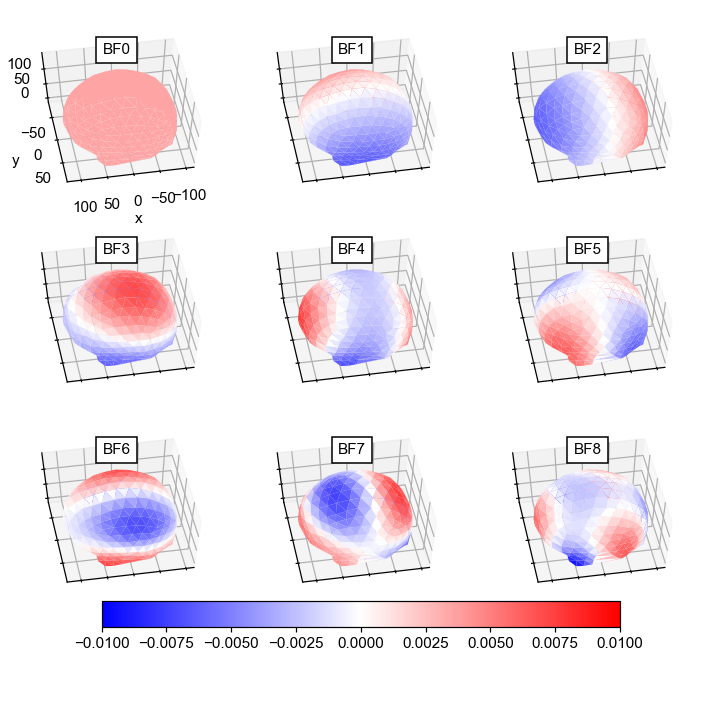

In [11]:
figsb1, axes1 = plt.subplots(nrows=3, ncols=3, figsize=(6.4, 6.4),
                             subplot_kw={'projection': '3d'})
for i in range(np.size(axes1)):
    colors = np.mean(basis_functions_fem[trilist, i + 0], axis=1)
    ax = axes1.flat[i]
    if i == 0:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    ax.view_init(elev=60., azim=80.)
    ax.set_aspect('equal')
    ax.add_artist(AnchoredText('BF' + str(i), frameon=True, loc='upper center'))
    # ax.text2D(0, 0.8, 'local max')
    trisurfplot = ax.plot_trisurf(vertlist[:, 0], vertlist[:, 1],
                                  vertlist[:, 2], triangles=trilist,
                                  cmap=plt.cm.bwr,
                                  edgecolor='white', linewidth=0.)
    trisurfplot.set_array(colors)
    trisurfplot.autoscale()
    trisurfplot.set_clim(-0.01, 0.01)

cbar = figsb1.colorbar(trisurfplot, ax=axes1.ravel().tolist(), shrink=0.95,
                       orientation='horizontal', fraction=0.05, pad=0.05,
                       anchor=(0.5, 0))

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.15, top=1.0, wspace=0.01, hspace=0.01)
plt.show()
figsb1.savefig('sphara_bf_lowfreq.pdf')

### SPHARA transform of the EEG data

Subsequently we perform the SPHARA transformation of the EEG data. As a result, a butterfly plot of all channels of the EEG is compared to the visualization of the power contributions of the first 40 SPHARA basis functions. Only the first 40 out of 256 basis functions are used for the visualization, since the power contribution of the higher basis functions is very low.

In [12]:
# perform the SPHARA transform
sphara_trans_eegdata = sphara_transform_fem.analysis(eegdata.transpose())

<IPython.core.display.Javascript object>


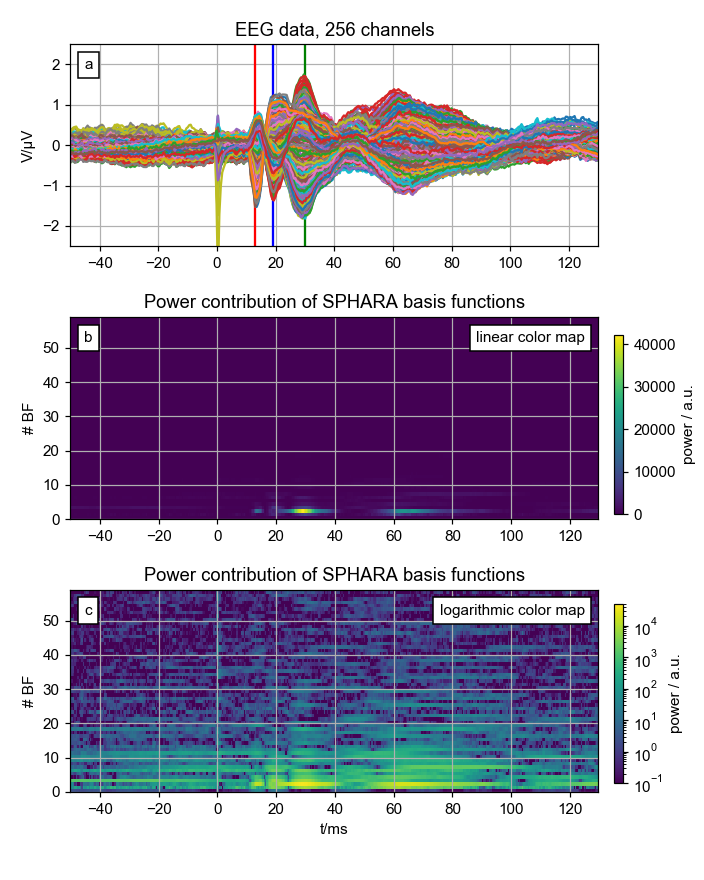

In [13]:
# 60 low-frequency basis functions are displayed
ysel = 60
figsteeg, (axsteeg1, axsteeg2, axsteeg3) = plt.subplots(nrows=3, figsize=(6.4, 8.0))

y = np.arange(0, ysel)
x = np.arange(-50, 130, 1/2.048)

axsteeg1.axvline(13, color='red')
axsteeg1.axvline(19, color='blue')
axsteeg1.axvline(30, color='green')
axsteeg1.plot(x, eegdata[:, :].transpose())
axsteeg1.set_ylabel('V/µV')
axsteeg1.set_title('EEG data, 256 channels')
axsteeg1.set_ylim(-2.5, 2.5)
axsteeg1.set_xlim(-50, 130)
axsteeg1.grid(True)
axsteeg1.add_artist(AnchoredText("a", frameon=True, loc='upper left'))

pcm2 = axsteeg2.pcolormesh(x, y,
                          np.square(np.abs(sphara_trans_eegdata.transpose()
                                           [0:ysel, :])),
                         linewidth=0.0,rasterized=True)
axsteeg2.set_ylabel('# BF')
axsteeg2.set_title('Power contribution of SPHARA basis functions')
axsteeg2.grid(True)
axsteeg2.add_artist(AnchoredText("b", frameon=True, loc='upper left'))
axsteeg2.add_artist(AnchoredText("linear color map", frameon=True, loc='upper right'))
figsteeg.colorbar(pcm2, ax=[axsteeg2], shrink=0.9,
                  anchor=(0.85, 1.5), label='power / a.u.')

pcm3 = axsteeg3.pcolormesh(x, y,
                          np.square(np.abs(sphara_trans_eegdata.transpose()
                                           [0:ysel, :])),
                         norm=LogNorm(vmin=0.1,vmax=50000),
                         linewidth=0.0,rasterized=True)
axsteeg3.set_xlabel('t/ms')
axsteeg3.set_ylabel('# BF')
axsteeg3.set_title('Power contribution of SPHARA basis functions')
axsteeg3.grid(True)
axsteeg3.add_artist(AnchoredText("c", frameon=True, loc='upper left'))
axsteeg3.add_artist(AnchoredText("logarithmic color map", frameon=True, loc='upper right'))
figsteeg.colorbar(pcm3, ax=[axsteeg3], shrink=0.9,
                  anchor=(0.85, 0.0), label='power / a.u.')

plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.95, hspace=0.35)
plt.show()
figsteeg.savefig('sep_butterfly_sphara_analysis_v2.pdf')

## SPHARA filter using FEM discretisation

### Create a SpharaPy SpharaFilter instance

 In the following step of the tutorial we determine an instance of the class SpharaFilter, which is used to execute the spatial filtering. For the determination of the SPHARA basis we use a Laplace-Beltrami operator, which is discretized by the FEM approach.

In [14]:
sphara_filter_fem = sf.SpharaFilter(mesh_eeg, mode='fem',
                                    specification=20)

### SPHARA filtering of the EEG data

In the next step we perform the SPHARA filtering of the EEG data. As a result, the butterfly plots of all channels of the EEG with and without filtering is compared. For the marked time samples also topo plots are provided.

In [15]:
# perform the SPHARA filtering
sphara_filt_eegdata = sphara_filter_fem.filter(eegdata.transpose()).transpose()

<IPython.core.display.Javascript object>


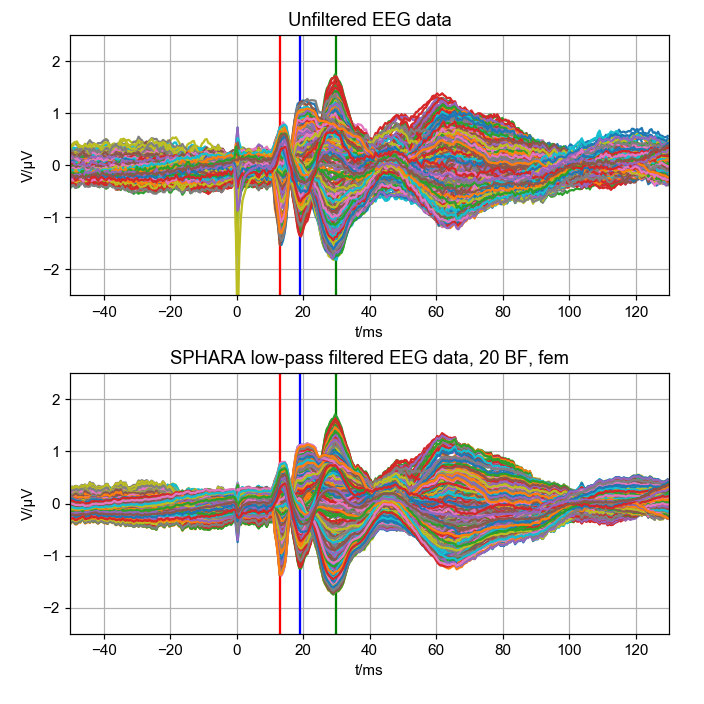

In [16]:
figsteeg, (axsteeg1, axsteeg2) = plt.subplots(nrows=2, figsize=(6.4, 6.4))

axsteeg1.axvline(13, color='red')
axsteeg1.axvline(19, color='blue')
axsteeg1.axvline(30, color='green')
axsteeg1.plot(x, eegdata[:, :].transpose())
axsteeg1.set_title('Unfiltered EEG data')
axsteeg1.set_ylabel('V/µV')
axsteeg1.set_xlabel('t/ms')
axsteeg1.set_ylim(-2.5, 2.5)
axsteeg1.set_xlim(-50, 130)
axsteeg1.grid(True)

axsteeg2.axvline(13, color='red')
axsteeg2.axvline(19, color='blue')
axsteeg2.axvline(30, color='green')
axsteeg2.plot(x, sphara_filt_eegdata[:, :].transpose())
axsteeg2.set_title('SPHARA low-pass filtered EEG data, 20 BF, fem')
axsteeg2.set_ylabel('V/µV')
axsteeg2.set_xlabel('t/ms')
axsteeg2.set_ylim(-2.5, 2.5)
axsteeg2.set_xlim(-50, 130)
axsteeg2.grid(True)

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.3)
plt.show()
figsteeg.savefig('sep_butterfly_filt.pdf')

<IPython.core.display.Javascript object>


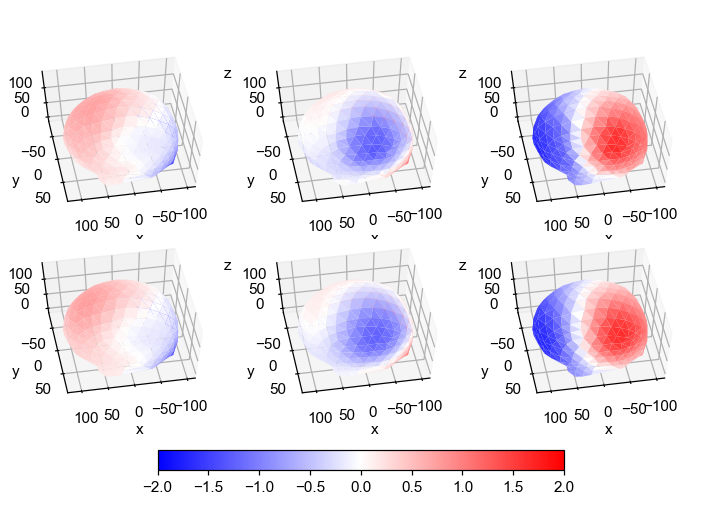

In [17]:
time_pts = [129, 141, 164]
figsf1, axessf1 = plt.subplots(nrows=2, ncols=3, figsize=(6.4, 4.8),
                               subplot_kw={'projection': '3d'})

for i in range(2):
    for j in range(3):
        if i == 0:
            colorssf1 = np.mean(eegdata[trilist, time_pts[j]], axis=1)
        else:
            colorssf1 = np.mean(sphara_filt_eegdata[trilist, time_pts[j]],
                                axis=1)
        
        axessf1[i, j].set_xlabel('x')
        axessf1[i, j].set_ylabel('y')
        axessf1[i, j].set_zlabel('z')
        axessf1[i, j].view_init(elev=60., azim=80.)
        axessf1[i, j].set_aspect('equal')

        trisurfplot = axessf1[i, j].plot_trisurf(vertlist[:, 0],
                                                 vertlist[:, 1],
                                                 vertlist[:, 2],
                                                 triangles=trilist,
                                                 cmap=plt.cm.bwr,
                                                 edgecolor='white',
                                                 linewidth=0.)
        trisurfplot.set_array(colorssf1)
        trisurfplot.set_clim(-2., 2)

cbar = figsb1.colorbar(trisurfplot, ax=axessf1.ravel().tolist(), shrink=0.85,
                       orientation='horizontal', fraction=0.05, pad=0.05,
                       anchor=(0.5, 0.0))

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.225, top=0.95,
                    wspace=0.0, hspace=0.0)
plt.show()
figsf1.savefig('sep_topo_filt.pdf')

### Application of the the spatial SPHARA filter to data with artificial noise

In a final step the EEG data are disturbed by white noise with different noise levels (3dB, 0dB and -3dB). A spatial low-pass SPHARA filter with 20 basis functions is applied to these data.

In [30]:
# vector with noise levels in dB
db_val_vec = [3, 0, -3]

# compute the power of the SEP data
power_sep = np.sum(np.square(np.absolute(eegdata))) / eegdata.size

# compute a vector with standard deviations of the noise in relation
# to signal power for the given noise levels
noise_sd_vec = list(map(lambda db_val:
                    np.sqrt(power_sep / (10 ** (db_val / 10))),
                        db_val_vec))

# add the noise to the EEG data
eegdata_noise = list(map(lambda noise_sd:
                         eegdata + np.random.normal(0, noise_sd, [256, 369]),
                         noise_sd_vec))

# filter the EEG data containing the artificial noise
eegdata_noise_filt = list(map(lambda eeg_noise:
                              (sphara_filter_fem.filter(eeg_noise.transpose()).
                               transpose()),
                              eegdata_noise))

 The results of the filtering are shown below as butterfly plots of all channels of the SEP data.

<IPython.core.display.Javascript object>


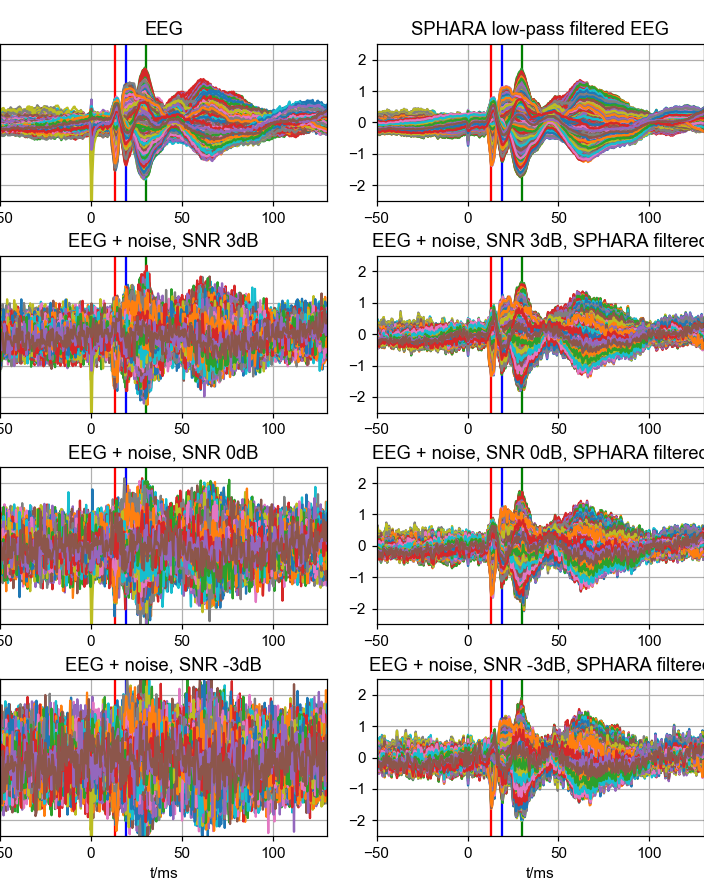

In [24]:
figfilt, axesfilt = plt.subplots(nrows=4, ncols=2, figsize=(6.4, 8.0))

axesfilt[0, 0].axvline(13, color='red')
axesfilt[0, 0].axvline(19, color='blue')
axesfilt[0, 0].axvline(30, color='green')
axesfilt[0, 0].plot(x, eegdata[:, :].transpose())
axesfilt[0, 0].set_title('EEG')
axesfilt[0, 0].set_ylabel('V/µV')
# axesfilt[0, 0].set_xlabel('t/ms')
axesfilt[0, 0].set_ylim(-2.5, 2.5)
axesfilt[0, 0].set_xlim(-50, 130)
axesfilt[0, 0].grid(True)

axesfilt[0, 1].axvline(13, color='red')
axesfilt[0, 1].axvline(19, color='blue')
axesfilt[0, 1].axvline(30, color='green')
axesfilt[0, 1].plot(x, sphara_filt_eegdata[:, :].transpose())
axesfilt[0, 1].set_title('SPHARA low-pass filtered EEG')
# axesfilt[0, 1].set_ylabel('V/µV')
# axesfilt[0, 1].set_xlabel('t/ms')
axesfilt[0, 1].set_ylim(-2.5, 2.5)
axesfilt[0, 1].set_xlim(-50, 130)
axesfilt[0, 1].grid(True)

for i in range(3):
    axesfilt[i + 1, 0].axvline(13, color='red')
    axesfilt[i + 1, 0].axvline(19, color='blue')
    axesfilt[i + 1, 0].axvline(30, color='green')
    axesfilt[i + 1, 0].plot(x, eegdata_noise[i].transpose())figfilt, axesfilt = plt.subplots(nrows=4, ncols=2, figsize=(6.4, 8.0))

axesfilt[0, 0].axvline(13, color='red')
axesfilt[0, 0].axvline(19, color='blue')
axesfilt[0, 0].axvline(30, color='green')
axesfilt[0, 0].plot(x, eegdata[:, :].transpose())
axesfilt[0, 0].set_title('EEG')
axesfilt[0, 0].set_ylabel('V/µV')
# a
    axesfilt[i + 1, 0].set_title('EEG + noise, SNR ' +
                                 str(db_val_vec[i]) + 'dB')
    axesfilt[i + 1, 0].set_ylabel('V/µV')
    if i == 2:
        axesfilt[i + 1, 0].set_xlabel('t/ms')
    axesfilt[i + 1, 0].set_ylim(-2.5, 2.5)
    axesfilt[i + 1, 0].set_xlim(-50, 130)
    axesfilt[i + 1, 0].grid(True)

    axesfilt[i + 1, 1].axvline(13, color='red')
    axesfilt[i + 1, 1].axvline(19, color='blue')
    axesfilt[i + 1, 1].axvline(30, color='green')
    axesfilt[i + 1, 1].plot(x, eegdata_noise_filt[i].transpose())
    axesfilt[i + 1, 1].set_title('EEG + noise, SNR ' +
                                 str(db_val_vec[i]) + 'dB, SPHARA filtered')
    # axesfilt[i + 1, 1].set_ylabel('V/µV')
    if i == 2:
        axesfilt[i + 1, 1].set_xlabel('t/ms')
    axesfilt[i + 1, 1].set_ylim(-2.5, 2.5)
    axesfilt[i + 1, 1].set_xlim(-50, 130)
    axesfilt[i + 1, 1].grid(True)

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.05, top=0.95, hspace=0.35,
                   wspace=0.15)
plt.show()
figfilt.savefig('sep_butterfly_noise_sim_filt.pdf')

 The results of the filtering are shown below as topo plots of all channels of the SEP data.

<IPython.core.display.Javascript object>


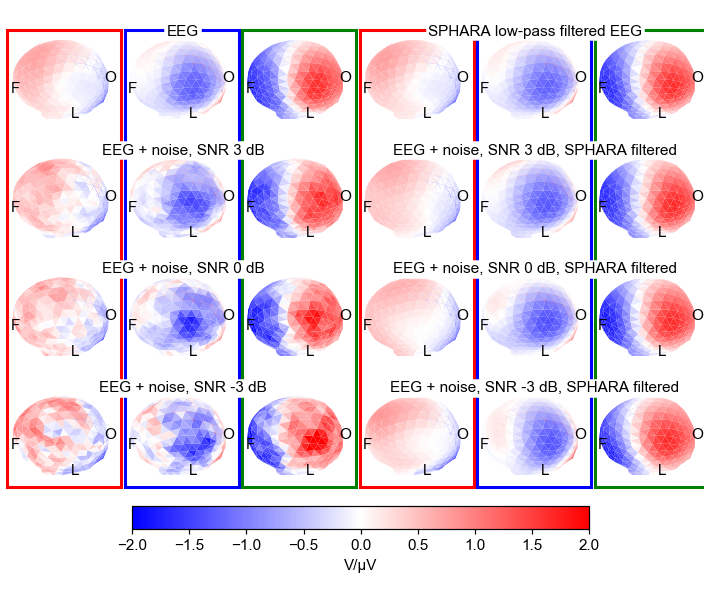

In [31]:
time_pts = [129, 141, 164]
figfilttopo, axesfilttopo = plt.subplots(nrows=4, ncols=6, figsize=(6.4, 5.4),
                               subplot_kw={'projection': '3d'})

for i in range(2):
    for j in range(3):

        if i == 0:
            colorssf1 = np.mean(eegdata[trilist, time_pts[j]], axis=1)
        else:
            colorssf1 = np.mean(sphara_filt_eegdata[trilist, time_pts[j]],
                                axis=1)

        #axesfilttopo[0, 3 * i + j].set_xlabel('x')
        #axesfilttopo[0, 3 * i + j].set_ylabel('y')
        #axesfilttopo[0, 3 * i + j].set_zlabel('z')
        axesfilttopo[0, 3 * i + j].view_init(elev=60., azim=80.)
        axesfilttopo[0, 3 * i + j].set_aspect('equal')
        axesfilttopo[0, 3 * i + j].grid(False)
        axesfilttopo[0, 3 * i + j].set_axis_off()
        axesfilttopo[0, 3 * i + j].dist = 6
        axesfilttopo[0, 3 * i + j].text(120,0,10,'F')
        axesfilttopo[0, 3 * i + j].text(-100,0,10,'O')
        axesfilttopo[0, 3 * i + j].text(0,80,10,'L')
        #axesfilttopo[0, 3 * i + j].text(0,-80,10,'R')


        trisurfplot = axesfilttopo[0, 3 * i + j].plot_trisurf(vertlist[:, 0],
                                                              vertlist[:, 1],
                                                              vertlist[:, 2],
                                                              triangles=trilist,
                                                              cmap=plt.cm.bwr,
                                                              edgecolor='white',
                                                              linewidth=0.)
        trisurfplot.set_array(colorssf1)
        trisurfplot.set_clim(-2., 2)
        
for i in range(3):
    for j in range(3):
        color_eeg_noise = np.mean(eegdata_noise[i][trilist, time_pts[j]], axis=1)
        color_eeg_filt = np.mean(eegdata_noise_filt[i][trilist, time_pts[j]], axis=1)
        
        #axesfilttopo[(i + 1), j].set_xlabel('x')
        #axesfilttopo[(i + 1), j].set_ylabel('y')
        #axesfilttopo[(i + 1), j].set_zlabel('z')
        axesfilttopo[(i + 1), j].view_init(elev=60., azim=80.)
        axesfilttopo[(i + 1), j].set_aspect('equal')
        axesfilttopo[(i + 1), j].grid(False)
        axesfilttopo[(i + 1), j].set_axis_off()
        axesfilttopo[(i + 1), j].dist = 6
        axesfilttopo[(i + 1), j].text(120,0,10,'F')
        axesfilttopo[(i + 1), j].text(-100,0,10,'O')
        axesfilttopo[(i + 1), j].text(0,80,10,'L')
        #axesfilttopo[(i + 1), j].text(0,-80,10,'R')

        
        trisurfplot = axesfilttopo[(i + 1), j].plot_trisurf(vertlist[:, 0],
                                                              vertlist[:, 1],
                                                              vertlist[:, 2],
                                                              triangles=trilist,
                                                              cmap=plt.cm.bwr,
                                                              edgecolor='white',
                                                              linewidth=0.)
        trisurfplot.set_array(color_eeg_noise)
        trisurfplot.set_clim(-2., 2)

        #axesfilttopo[(i + 1), 3 + j].set_xlabel('x')
        #axesfilttopo[(i + 1), 3 + j].set_ylabel('y')
        #axesfilttopo[(i + 1), 3 + j].set_zlabel('z')
        axesfilttopo[(i + 1), 3 + j].view_init(elev=60., azim=80.)
        axesfilttopo[(i + 1), 3 + j].dist=10
        axesfilttopo[(i + 1), 3 + j].set_aspect('equal')
        axesfilttopo[(i + 1), 3 + j].grid(False)
        axesfilttopo[(i + 1), 3 + j].set_axis_off()
        axesfilttopo[(i + 1), 3 + j].dist = 6
        axesfilttopo[(i + 1), 3 + j].text(120,0,10,'F')
        axesfilttopo[(i + 1), 3 + j].text(-100,0,10,'O')
        axesfilttopo[(i + 1), 3 + j].text(0,80,10,'L')
        #axesfilttopo[(i + 1), 3 + j].text(0,-80,10,'R')

        trisurfplot = axesfilttopo[(i + 1), 3 + j].plot_trisurf(vertlist[:, 0],
                                                              vertlist[:, 1],
                                                              vertlist[:, 2],
                                                              triangles=trilist,
                                                              cmap=plt.cm.bwr,
                                                              edgecolor='white',
                                                              linewidth=0.)
        trisurfplot.set_array(color_eeg_filt)
        trisurfplot.set_clim(-2., 2)

cbar = figfilttopo.colorbar(trisurfplot, ax=axesfilttopo.ravel().tolist(), shrink=0.95,
                       orientation='horizontal', label='V/µV', fraction=0.05, pad=0.05,
                       anchor=(0.5, 0.0))

figfilttopo.add_artist(Rectangle((0.01, 0.18), width=0.162, height=0.77, fill=False, color='red', lw=2))
figfilttopo.add_artist(Rectangle((0.177, 0.18), width=0.162, height=0.77, fill=False, color='blue', lw=2))
figfilttopo.add_artist(Rectangle((0.344, 0.18), width=0.162, height=0.77, fill=False, color='green', lw=2))
figfilttopo.add_artist(Rectangle((0.511, 0.18), width=0.162, height=0.77, fill=False, color='red', lw=2))
figfilttopo.add_artist(Rectangle((0.678, 0.18), width=0.162, height=0.77, fill=False, color='blue', lw=2))
figfilttopo.add_artist(Rectangle((0.845, 0.18), width=0.162, height=0.77, fill=False, color='green', lw=2))
figfilttopo.add_artist(Text(x=0.26, y=0.94, text='EEG', ha='center', 
                            bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.76, y=0.94, text='SPHARA low-pass filtered EEG',
                            ha='center', bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.26, y=0.74, text='EEG + noise, SNR 3 dB', ha='center',
                            bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.76, y=0.74, text='EEG + noise, SNR 3 dB, SPHARA filtered',
                            ha='center', bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.26, y=0.54, text='EEG + noise, SNR 0 dB', ha='center',
                            bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.76, y=0.54, text='EEG + noise, SNR 0 dB, SPHARA filtered',
                            ha='center', bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.26, y=0.34, text='EEG + noise, SNR -3 dB', ha='center',
                            bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))
figfilttopo.add_artist(Text(x=0.76, y=0.34, text='EEG + noise, SNR -3 dB, SPHARA filtered',
                            ha='center', bbox=dict(facecolor='white', edgecolor='white', pad=1.0)))

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.2, top=1.0, hspace=0.0,
                   wspace=0.0)

plt.show()
figfilttopo.savefig('sep_topo_noise_sim_filt.pdf')